# Clustering

Clustering is an unsupervised problem because the goal is to discover structure on the basis of data sets. Clustering looks to find homogeneous subgroups among the observations. 

The concept of homogeneity within group is parameterized with the *distance* between data.  There exist many other distance metrics, which can be called from the ``DistanceMetric`` sci-kit learn module. More details in this scikit-learn [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.metrics.DistanceMetric.html#sklearn.metrics.DistanceMetric).

Clustering and PCA both simplify the data via a small number of summaries. But the differences are:
* PCA seeks to reduce the dimensionality of the data, to find a low-dimensiona representation of the data that explains a good fraction of the data variance,
* Clustering seeks to find homogeneous groups within the observations.

In fact, it is common to combine both for complex and high dimensional data: 1) PCA, 2) clustering on the PCs.


There are two main methods using clustering, **k-means** clustering and **hierarchical clustering**.

The toolbox scikit-learn has a collection of clustering algorithms and detailed [documentation](!https://scikit-learn.org/stable/modules/clustering.html) with tutorials.


Import useful Python packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import wget
from math import cos, sin, pi, sqrt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
from sklearn.decomposition import PCA
import plotly.express as px

<frozen importlib._bootstrap>:228: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


### Data

We will use **flow cytometer data**. 
The file has attributes about each particle, such as normalized scatter, red, orange, and green. These are measurements from the instrument iteself from light scattering.
Other parameters, like diam (diameter) and Qc (carbon quota) are estimated from the light scatter measurements.

In [ ]:
# download data
cc=wget.download("https://www.dropbox.com/s/dwa82x6xhjkhyw8/ug3_FCM_distribution.feather?dl=1")

read the data

In [ ]:
# this is some underway data collected from a cruise in 2019

underway_g3 = pd.read_feather("ug3_FCM_distribution.feather")
print(underway_g3.columns)
underway_g3.head()

In [ ]:
files = list(pd.unique(underway_g3['filename']))
print(files)

Each file is 1 sample taken at a certain time, location, and depth. There are also replicates, or even triplicates, run on the same spatiotemporal scale to get uncertainty estimations on the instrument. We can either ignore the replicates/triplicates or take the mean. 

In [ ]:
test1 = underway_g3[underway_g3['filename']==files[1]]
px.scatter(test1, 'norm.scatter', 'norm.red', color='pop',log_x=True, log_y=True)

In [ ]:
px.scatter(test1, 'norm.scatter','norm.orange',color='pop',log_x=True,log_y=True)

Typically, populations are gated based on their log-transformed normalized scatter (x) and red (y). Orange flouresence can be used in addition to gate the synecho population. We can see there are 3 populations here, and these were previously gated from the parameters above. 

In [ ]:
import seaborn as sns
sns.set_theme(style="ticks")
df = test1[['norm.scatter','norm.red','norm.orange','norm.green','depth']]
df['norm.scatter'] = np.log10(df['norm.scatter'])
df['norm.red'] = np.log10(df['norm.red'])
df['norm.orange'] = np.log10(df['norm.orange'])
sns.pairplot(df, hue="norm.green")

In [ ]:
sns.set_theme(style="ticks")
df = test1[['norm.scatter','norm.red','norm.orange','pop']]
df['norm.scatter'] = np.log10(df['norm.scatter'])
df['norm.red'] = np.log10(df['norm.red'])
df['norm.orange'] = np.log10(df['norm.orange'])
sns.pairplot(df, hue="pop")

## 1. K-means
K-means is an unsupervised clustering method. The main idea is to separate the data into K distinct clusters. We then have two problems to solve. First, we need to find the k centroids of the k clusters. Then, we need to affect each data point to the cluster which centroid is the closest to the data point.

The goal is to partition $n$ data points into $k$ clusters. Each observation is labeled to a cluster with the nearest mean.

K-means is iterative:
1. assume initial values for the mean of each of the $k$ clusters
2. Compute the distance for each observation to each of the $k$ means
3. Label each observation as belonging to the nearest means
4. Find the *center of mass* (mean) of each group of labeled points. These are new means to step 1.


In the following, we denote $n$ the number of data points, and $p$ the number of features for each data point.

K-means only works with the **Euclidian distance** metrics. In fact, its core concept is to use the the euclidian distance to measure and minimize *inertia* or *within cluster variation*.

In [ ]:
n = len(df)
p = 3 #()
print('We have {:d} data points, and each one has {:d} features'.format(n, p))

Let's define a numpy array with the 3 features and all of the data

In [ ]:
data = np.zeros(shape=(n,p))
data[:,0] = df['norm.scatter']
data[:,1] = df['norm.red']
data[:,2] = df['norm.orange']

Let us define a function to initialize the centroid of the clusters. We choose random points within the range of values taken by the data.

In [ ]:
def init_centers(data, k):
    """
    """
    # Initialize centroids
    centers = np.zeros((k, np.shape(data)[1]))
    # Loop on k centers
    for i in range(0, k):
        # Generate p random values between 0 and 1
        dist = np.random.uniform(size=np.shape(data)[1])
        # Use the random values to generate a point within the range of values taken by the data
        centers[i, :] = np.min(data, axis=0) + (np.max(data, axis=0) - np.min(data, axis=0)) * dist
    return centers

To be able to affect each data point to the closest centroid, we need to define the distance between two data points. The most common distance is the **Euclidean distance**:

$d(x,y) = \sqrt{\sum_{i = 1}^p (x_i - y_i)^2}$

where $x$ and $y$ are two data observation points with $p$ variables. 

We then define a function to compute the distance between each data point and each centroid.

In [ ]:
def compute_distance(data, centers, k):
    """
    """
    # Initialize distance
    distance = np.zeros((np.shape(data)[0], k))
    # Loop on n data points
    for i in range(0, np.shape(data)[0]):
        # Loop on k centroids
        for j in range(0, k):
            # Compute distance
            distance[i, j] = sqrt(np.sum(np.square(data[i, :] - centers[j, :])))
    return distance

We now define a function to affect each data point to the cluster which centroid is the closest to the point. We also define an objective function that will be minimized until we reach convergence.

Our objective is to minimize the sum of the square of the distance between each point and the closest centroid:

$obj = \sum_{j = 1}^k \sum_{i = 1}^{N_j} d(x^{(i)} , x^{(j)}) ^2$

where $x^{(i)}$ is the $i^{th}$ point in the cluster $j$, $x^{(j)}$ is the centroid of the cluster $j$, and $N_j$ is the number of points in the cluster $j$.

In [ ]:
def compute_objective(distance, clusters):
    """
    """
    # Initialize objective
    objective = 0.0
    # Loop on n data points
    for i in range(0, np.shape(distance)[0]):
        # Add distance to the closest centroid
        objective = objective + distance[i, int(clusters[i])] ** 2.0
    return objective

In [ ]:
def compute_clusters(distance):
    """
    """
    # Initialize clusters
    clusters = np.zeros(np.shape(distance)[0])
    # Loop on n data points
    for i in range(0, np.shape(distance)[0]):
        # Find closest centroid
        best = np.argmin(distance[i, :])
        # Assign data point to corresponding cluster
        clusters[i] = best
    return clusters

After all points are assigned to a cluster, compute the new location of the centroid. It is just the value of the mean of all the points affected to that cluster:

For $1 \leq j \leq k$, $x_p^{(j)} = \frac{1}{N_j} \sum_{i = 1}^{N_j} x_p^{(i)}$

In [ ]:
def compute_centers(data, clusters, k):
    """
    """
    # Initialize centroids
    centers = np.zeros((k, np.shape(data)[1]))
    # Loop on clusters
    for i in range(0, k):
        # Select all data points in this cluster
        subdata = data[clusters == i, :]
        # If no data point in this cluster, generate randomly a new centroid
        if (np.shape(subdata)[0] == 0):
            centers[i, :] = init_centers(data, 1)
        else:
            # Compute the mean location of all data points in this cluster
            centers[i, :] = np.mean(subdata, axis=0)
    return centers

We can now code the K-means algorithm by assembling all these functions. We stop the computation when the objective function no longer decreases.

In [ ]:
def my_kmeans(data, k):
    """
    """
    # Initialize centroids
    centers = init_centers(data, k)
    # Initialize objective function to maximum square of distance between to data points time number od data points
    objective_old = np.shape(data)[0] * np.sum(np.square(np.max(data, axis=0) - np.min(data, axis=0)))
    # Initialize clusters
    clusters_old = np.zeros(np.shape(data)[0])
    # Start loop until convergence
    stop_alg = False
    while stop_alg == False:
        # Compute distance between data points and centroids
        distance = compute_distance(data, centers, k)
        # Get new clusters
        clusters_new = compute_clusters(distance)
        # get new value of objective function
        objective_new = compute_objective(distance, clusters_new)
        # If objective function stops decreasing, end loop
        if objective_new >= objective_old:
            return (clusters_old, objective_old, centers)
        else:
            # Update the locations of the centroids
            centers = compute_centers(data, clusters_new, k)
            objective_old = objective_new
            clusters_old = clusters_new

Run K-means with 4 clusters

In [ ]:
k = 4
(clusters, objective, centers) = my_kmeans(data, k)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 1], data[:, 0], -data[:, 2], c=clusters)
ax.scatter(centers[:, 1], centers[:, 0], -centers[:, 2], marker='o', s=300, c='black')
ax.set_xlabel('norm.scatterer')
ax.set_ylabel('norm.red')
ax.set_ylabel('norm.orange')
plt.title('Clusters for cytometer data')

### K-means with Scikit learn

We will now use [scikit learn](!https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#) toolbox to run kmeans. Follow that tutorial and apply it to your problem.



In [ ]:

from sklearn.cluster import KMeans

X = data
Y = np.asarray(df['pop'])

kmeans = KMeans(n_clusters=2, random_state=0).fit(data)
kmeans.labels_



In [ ]:
# explore different pipeline


estimators = [
    ("k_means_cyto_8", KMeans(n_clusters=8)),
    ("k_means_cyto_3", KMeans(n_clusters=3)),
    ("k_means_cyto_bad_init", KMeans(n_clusters=3, n_init=1, init="random")),
]

name,est=estimators[0]
est.fit(X)
labels = est.labels_

fig = plt.figure(0, figsize=(4, 3))
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels.astype(float), edgecolor="k")
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel("norm.scatter")
ax.set_ylabel("norm.red")
ax.set_zlabel("norm.orange")
fig.show()

### Practical tips for k-means

1. How to **evaluate the success** of the clustering? How well separated are the clusters? There exist many ways to evaluate the quality of the clusters. Scikit-learn has summarized and packaged these tools into the module ``sklearn.metrics``. See documentation [here](!https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation). Usually, high scores are better. Here is a summary:
    * If the data has ground-truth labels (e.g., population of the cyto data), we can use several metrics:
        + **homogeneity** (each cluster contains only members of a given class, ``metrics.homgeneity_score(clusterID,true_label)``), **completeness** (all members of a given class are assigned the same cluster, ``metrics.completeness_score``), V-measure (2 x homogeneity x completeness / (homogeneity+completeness), ``metrics.v_measure_score``) and all three ``metrics.homogeneity_completeness_v_measure(clusterID,true_label)``.
        +  **Fowlkes-Mallows index**, FMI, that uses TP (True Positive), FP (False Positive), FN (False Negative). Is 0.0 for random cluster assignement and 1.0 for perfect label assignements.
    * If the data does not have ground truth label, you can use:
        + **silhouette coefficient** using the module ``metrics.silhouette_score)``, a high score or coefficient is better. It quantifies how tight the data within the clusters are and how well separated the clusters are. More details on implementation and visualization of the **silhouette score** [here](!https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).
2. The number of clusters $k$ is a tunable parameter. To find the optimal number of clusters, we discuss below a few strategies.
3. The optimization of k-means may have local minima. The result therefore may different due to the initialiation of the clusters. It is recommended to use:
    * repeat random initialization, repeat k-means, and use the best set of cluster (one that has the lowest final error)
    * choose K-means++ initialization scheme using the sklearn parameter ``init='k-means++'``. The algorithm selects initial cluster centroids using sampling based on an empirical probability distribution of the points’ contribution to the overall inertia. 

4. The **data variance** of some of the features may affect the results. It may be difficult to find clusters if some of the data features (axis) are much larger than other. The data may need to be pre-processed (centered and scaled) or pre-conditions (e.g., PCA).



In the following, we take the example of a simple data sets. The Old Faithful is a geyser in Yellowstone. The data shows the time of the geyser eruption against the waiting time for the next eruptions.

Text(0.5, 1.0, 'Old Faithful')

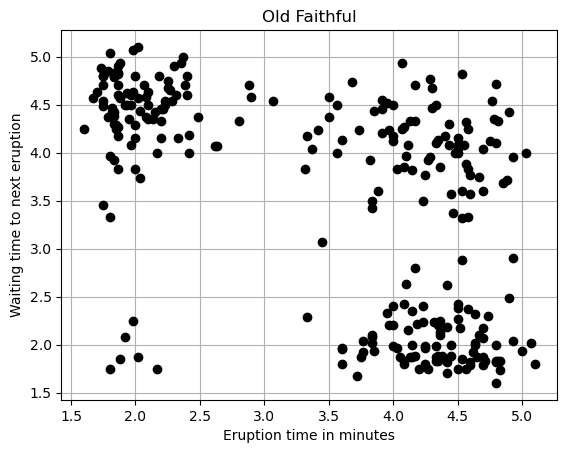

In [4]:
faithful = pd.read_csv('faithful.csv')
data_faithful = faithful.to_numpy()
plt.plot(faithful.current, faithful.next, 'ko')
plt.xlabel('Eruption time in minutes')
plt.ylabel('Waiting time to next eruption')
plt.grid(True)
plt.title('Old Faithful')

Example of **silhouette analysis**

In [8]:
# example of the silhouette score for the Old Faithful data
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score, silhouette_sample

ncluster=3

kmeans_model = KMeans(n_clusters=ncluster, random_state=1).fit(data_faithful)
labels = kmeans_model.labels_
sc=silhouette_score(data_faithful, labels, metric='euclidean')
print(silhouette_sample(data_faithful, labels, metric='euclidean'))

print(sc)

ImportError: cannot import name 'silhouette_sample' from 'sklearn.metrics' (/Users/marinedenolle/.conda/envs/mlgeo_sk/lib/python3.9/site-packages/sklearn/metrics/__init__.py)

NameError: name 'ncluster' is not defined

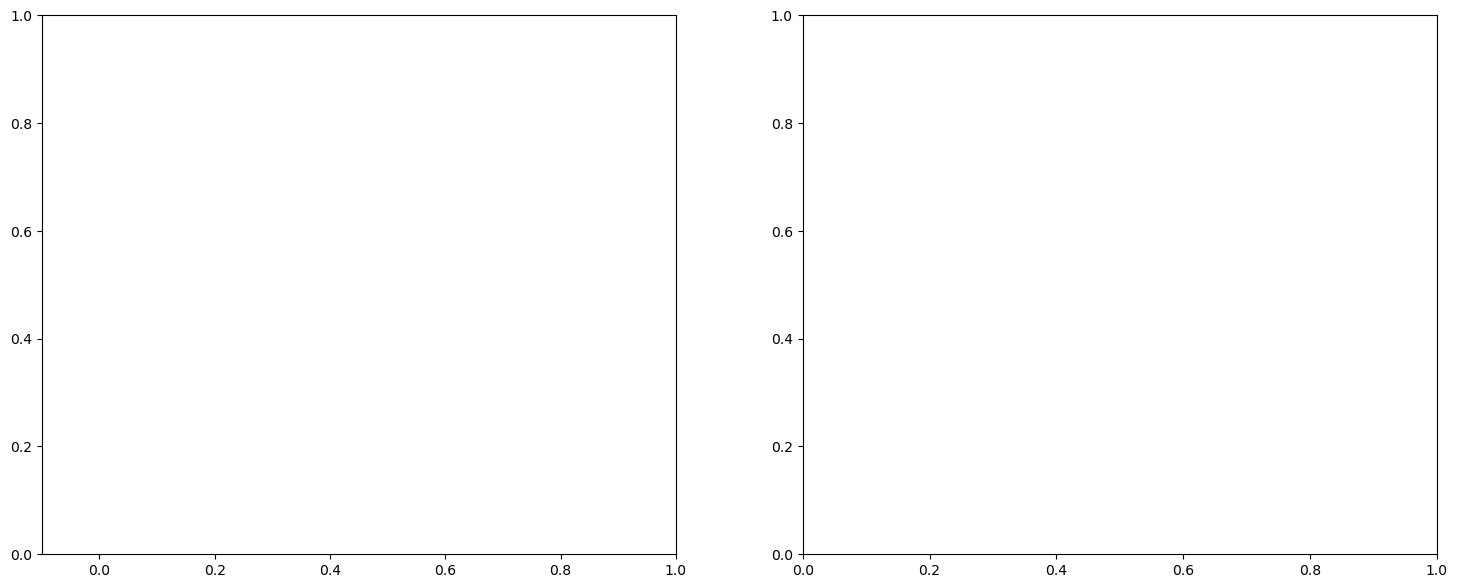

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
#The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(data_faithful) + (ncluster + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
clusterer = KMeans(n_clusters=ncluster, random_state=10)
cluster_labels = clusterer.fit_predict(data_faithful)

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(data_faithful, cluster_labels)
print(
    "For n_clusters =",
    ncluster,
    "The average silhouette_score is :",
    silhouette_avg,
)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_sample(data_faithful, cluster_labels)

#### (2) Choice of number of clusters: The Elbow Method

The elbow method is designed to find the optimal number of clusters. It consists in performing the clustering algorithm with an increasing number of clusters $k$ and select and measuring the average distance between data points and the cluster centroids. There are two typical metrics in the Elbow method

* **Distortion**: It is calculated as the average of the squared distances from the cluster centers of the respective clusters. Typically, the Euclidean distance metric is used.
* **Inertia**: It is the sum of squared distances of samples to their closest cluster center.

For each value of $k$, we compute the mean of the square of the distance between the data points and the centroid of the cluster to which they belong. We then plot this value as a function of $k$. Hopefully, it decreases and then reaches a plateau. The optimal number of clusters is the value for which it attains the minimum.

Let us use a different dataset to illustrate the elbow method.

In [ ]:
def compute_elbow(data, clusters, centers, k):
    """
    """
    E = 0
    for i in range(0, k):
        distance = compute_distance(data[clusters == i, :], centers[i, :].reshape(1, -1), 1)
        E = E + np.mean(np.square(distance))
    return E

Compute the value of E for different values of the number of clusters

In [ ]:
E = np.zeros(8)
for k in range(1, 9):
    (clusters, objective, centers) = my_kmeans(data_faithful, k)
    E[k - 1] = compute_elbow(data_faithful, clusters, centers, k)

Plot $E$ as a function of $k$ and see where reaches a minimum.

In [ ]:
plt.plot(np.arange(1, 9), E)

The elbow method does not always work very well. For example, see what happens when the points get closer to each other.

In [ ]:
alpha = 0.5
origin = np.array([3, 3])
data_shrink = origin + alpha * np.sign(data_faithful - origin) * np.power(np.abs(data_faithful - origin), 2.0)
plt.plot(data_shrink[:, 0], data_shrink[:, 1], 'ko')

E = np.zeros(8)
for k in range(1, 9):
    (clusters, objective, centers) = my_kmeans(data_shrink, k)
    E[k - 1] = compute_elbow(data_shrink, clusters, centers, k)
plt.plot(np.arange(1, 9), E)

Let us see what happens when we decrease the number of data

In [ ]:
alpha = 0.2
indices = np.random.uniform(size=np.shape(data_faithful)[0])
subdata = data_faithful[indices < alpha, :]
plt.plot(subdata[:, 0], subdata[:, 1], 'ko')
E = np.zeros(8)
for k in range(1, 9):
    (clusters, objective, centers) = my_kmeans(subdata, k)
    E[k - 1] = compute_elbow(subdata, clusters, centers, k)
plt.plot(np.arange(1, 9), E)

#### (2) Repeat K-means
Result is very sensitive to the location of the initial centroid. Repeat the clustering N times and choose the clustering with the best objective function


In [ ]:
def repeat_kmeans(data, k, N):
    """
    """
    # Initialization
    objective = np.zeros(N)
    clusters = np.zeros((N, np.shape(data)[0]))
    centers = np.zeros((N, k, np.shape(data)[1]))
    # Run K-means N times
    for i in range(0, N):
        result = my_kmeans(data, k)
        clusters[i, :] = result[0]
        objective[i] = result[1]
        centers[i, :, :] = result[2]
    # Choose the clustering with the best value of the objective function
    best = np.argmin(objective)
    return (clusters[best, :], objective[best], centers[best, :, :])

Repeat k-means 50 times

In [ ]:
N = 50
(clusters, objective, centers) = repeat_kmeans(data, k, N)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 1], data[:, 2], -data[:, 0], c=clusters)
ax.scatter(centers[:, 1], centers[:, 2], -centers[:, 0], marker='o', s=300, c='black')

## PCA before clustering

Let us generate synthetics data.

In [ ]:
centers = np.array([[2, 2], [2, 8], [4, 3]])
radius = [0.1, 1]
synthetics = np.empty([0, 2])
for i in range(0, 3):
    X = centers[i, 0] + radius[0] * np.random.randn(100)
    Y = centers[i, 1] + radius[1] * np.random.randn(100)
    U = (X + Y) * sqrt(2) / 2
    V = (X - Y) * sqrt(2) / 2
    synthetics = np.concatenate([synthetics, np.vstack((U, V)).T])
plt.plot(synthetics[:,0], synthetics[:,1], 'ko')
plt.xlim(1, 9)
plt.ylim(-6, 3)

Let us now do k-means clustering with 3 clusters.

In [ ]:
random.seed(0)
(clusters, objective, centers) = my_kmeans(synthetics, 3)
plt.scatter(synthetics[:,0], synthetics[:,1], c=clusters)

What happens if we apply PCA + normalization before the clustering?

In [ ]:
pca = PCA(n_components=2)
synthetics_pca = pca.fit_transform(synthetics)

In [ ]:
scaler = preprocessing.StandardScaler().fit(synthetics_pca)
synthetics_scaled = scaler.transform(synthetics_pca)

In [ ]:
(clusters, objective, centers) = kmeans_pp(synthetics_scaled, 3)
plt.scatter(synthetics[:,0], synthetics[:,1], c=clusters)